# ROMY Status File

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame, merge


In [2]:
from functions.load_status import __load_status

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

# specify time interval
config['tend'] = obs.UTCDateTime().now()
config['tbeg'] = obs.UTCDateTime(f"{config['tend'].year}-01-01")

# select day before yesterday
config['date_before'] = obs.UTCDateTime((config['tend'] - 2*86400).date)

# path to figure output
config['path_to_figs'] = data_path+f"HTML_Monitor/figures/"

# path to quality data archive
config['path_to_data'] = archive_path+f"temp_archive/"

# define name of rings
config['names'] = ["RZ", "RU", "RV", "RW"]


In [5]:
def __get_stats(df0):

    names = ["RZ", "RU", "RV", "RW"]

    ## make statistics
    df_stats = DataFrame(columns=["ring", "R_0", "R_1", "R_nan", "R_N", "R_0_p", "R_1_p", "R_nan_p"])

    R_0, R_1, R_nan = np.zeros(len(names)), np.zeros(len(names)), np.zeros(len(names))
    for _n, k in enumerate(names):

        R_0 = df0[k][df0[k] == 0].size
        R_1 = df0[k][df0[k] == 1].size
        R_nan = df0[k][df0[k].isnull()].size
        R_N = df0[k].size

        if R_N == 0:
            R_N = np.nan

        R_0_p = round(R_0/R_N*100, 2)
        R_1_p = round(R_1/R_N*100, 2)
        R_nan_p = round(R_nan/R_N*100, 2)

        df_stats.loc[len(df_stats)] = [k, R_0, R_1, R_nan, R_N, R_0_p, R_1_p, R_nan_p]

    return df_stats

### Load Status Data

In [6]:

try:
    statusZ = __load_status(config['tbeg'], config['tend'], "Z", config['path_to_data'])

    statusZ = statusZ.sort_values(by="times_utc").reset_index()
except:
    pass

try:
    statusU = __load_status(config['tbeg'], config['tend'], "U", config['path_to_data'])

    statusU = statusU.sort_values(by="times_utc").reset_index()
except:
    pass

try:
    statusV = __load_status(config['tbeg'], config['tend'], "V", config['path_to_data'])

    statusV = statusV.sort_values(by="times_utc").reset_index()
except:
    pass

try:
    statusW = __load_status(config['tbeg'], config['tend'], "W", config['path_to_data'])

    statusW = statusW.sort_values(by="times_utc").reset_index()
except:
    pass


 -> 2 missing files
 -> 0 errors occurred
 -> 6 missing files
 -> 0 errors occurred
 -> 2 missing files
 -> 0 errors occurred
 -> 214 missing files
 -> 0 errors occurred


### Pre-Processing

In [7]:
try:
    statusZ_mod = statusZ[['times_utc','quality']]
    statusZ_mod = statusZ_mod.dropna(subset="times_utc").reset_index()
    statusZ_mod['times_utc'] = statusZ_mod.times_utc.astype(str)
except:
    pass

try:
    statusU_mod = statusU[['times_utc','quality']]
    statusU_mod = statusU_mod.dropna(subset="times_utc").reset_index()
    statusU_mod['times_utc'] = statusU_mod.times_utc.astype(str)
except:
    pass

try:
    statusV_mod = statusV[['times_utc','quality']]
    statusV_mod = statusV_mod.dropna(subset="times_utc").reset_index()
    statusV_mod['times_utc'] = statusV_mod.times_utc.astype(str)
except:
    pass

try:
    statusW_mod = statusW[['times_utc','quality']]
    statusW_mod = statusW_mod.dropna(subset="times_utc").reset_index()
    statusW_mod['times_utc'] = statusW_mod.times_utc.astype(str)
except:
    pass

### Form one Data Frame

In [8]:
# create new frame with all rings and their quality
df_new = statusZ_mod.copy()

try:
    df_new = df_new.merge(statusU_mod, how="outer", on=["times_utc"])

    # drop irrelevant columns
    df_new.drop(columns=["index_x", "index_y"], inplace=True)

    # renaming ...
    df_new.rename(columns={"quality_x":"RZ", "quality_y":"RU"}, inplace=True)

except:
    pass


In [9]:
try:
    df_new = df_new.merge(statusV_mod, how="outer", on=["times_utc"])

    # drop irrelevant columns
    df_new.drop(columns=["index"], inplace=True)

    # renaming ...
    df_new.rename(columns={"quality":"RV"}, inplace=True)

except:
    pass


In [10]:
try:
    df_new = df_new.merge(statusW_mod, how="outer", on=["times_utc"])

    # drop irrelevant columns
    df_new.drop(columns=["index"], inplace=True)

    # renaming ...
    df_new.rename(columns={"quality":"RW"}, inplace=True)

except:
    pass


In [11]:
# add relative times
ref_time = df_new.times_utc.iloc[0]
df_new['times_utc_sec'] = np.array([abs(obs.UTCDateTime(ref_time) - obs.UTCDateTime(_t) +30) for _t in df_new.times_utc])

# add RW column
# df_new['RW'] = np.ones(df_new.shape[0])*np.nan

# sort all by time
df_new.sort_values(by="times_utc", inplace=True)

In [12]:
# sub data frame for one day
df_day_before = df_new.copy()
df_day_before = df_day_before[df_day_before.times_utc > config['date_before']]
df_day_before = df_day_before[df_day_before.times_utc < config['date_before']+86400]

# sub data frame for this month
month = config['tend'].month
df_new['month'] = [obs.UTCDateTime(_t).month for _t in df_new.times_utc]
df_month = df_new[df_new.month == config['tend'].month]
df_month = df_month[df_month.times_utc > config['date_before']]
df_month = df_month[df_month.times_utc < config['date_before']+86400]

# sub data frame for the entire year
df_year = df_new.copy()

### Plotting

In [13]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 6, 2

    font = 14

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 8))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.25, wspace=0.5)

    ax1 = fig.add_subplot(gs1[0, 0:2])
    ax2 = fig.add_subplot(gs1[0, 2:4])
    ax3 = fig.add_subplot(gs1[0, 4:6])
    ax4 = fig.add_subplot(gs1[1, :])

    # create colormap green - red
    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])
    cmap.set_bad("w")

    # ___________________________________________________

    for ax, _df in zip([ax1, ax2, ax3], [df_day_before, df_month, df_year]):

        df_stats = __get_stats(_df)

        barWidth = 0.85

        r = range(df_stats.ring.size)

        ax.bar(r, df_stats.R_0_p,
                color='darkred', edgecolor='k', width=barWidth, label="Bad Quality")

        ax.bar(r, df_stats.R_1_p, bottom=df_stats.R_0_p,
                color='green', edgecolor='k', width=barWidth, label="Good Quality")

        ax.bar(r, df_stats.R_nan_p, bottom=[i+j for i, j in zip(df_stats.R_0_p, df_stats.R_1_p)],
                color='white', edgecolor='k', width=barWidth, label="NaN")

        ax.set_xticks(r, df_stats.ring)

        ax.set_ylim(0, 100)

        vals = ax.get_yticks()
        ax.set_yticklabels([f'{int(x)}%' for x in vals])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        for c in ax.containers:

            # Optional: if the segment is small or 0, customize the labels
            labels = [round(v.get_height(), 2) if v.get_height() > 0 else '' for v in c]

            # remove the labels parameter if it's not needed for customized labels
            plt.bar_label(c, labels=labels, label_type='center', padding=0)

    ax3.set_title(f"For {config['tbeg'].year}", pad=10)
    ax2.set_title(f"For {config['tbeg'].year}-{str(config['tend'].month).rjust(2, '0')}", pad=10)
    ax1.set_title(f"For {config['date_before'].date}", pad=10)

    ax2.legend(loc='upper left', bbox_to_anchor=(-0.1, -0.1), ncol=3)

    # ___________________________________________________

    bars = np.ones(4)-0.5

    arr = np.ones((4, df_day_before.shape[0]))

    for _n, name in enumerate(config['names']):
        arr[_n] *= df_day_before[name]

    times = df_day_before.times_utc_sec - df_day_before.times_utc_sec.iloc[0]

    c = ax4.pcolormesh(times/3600, config['names'], arr, cmap=cmap, rasterized=True, alpha=1)

    for _k, bar in enumerate(bars):
        ax4.axhline(bar+_k, color="w", alpha=1, lw=2)

    ax4.tick_params(axis='y', labelsize=font)
    ax4.tick_params(axis='x', labelsize=font-2)

    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    ax4.set_xlabel(f"Time (hours) from {config['date_before'].date}", fontsize=font)

    # add minor ticks
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    ax4.set_xlim(left=0)
    ax4.xaxis.set_major_locator(MultipleLocator(5))
    ax4.xaxis.set_minor_locator(MultipleLocator(1))

    return fig

/tmp/ipykernel_2873299/2374872829.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in vals])
/tmp/ipykernel_2873299/2374872829.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in vals])
/tmp/ipykernel_2873299/2374872829.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in vals])


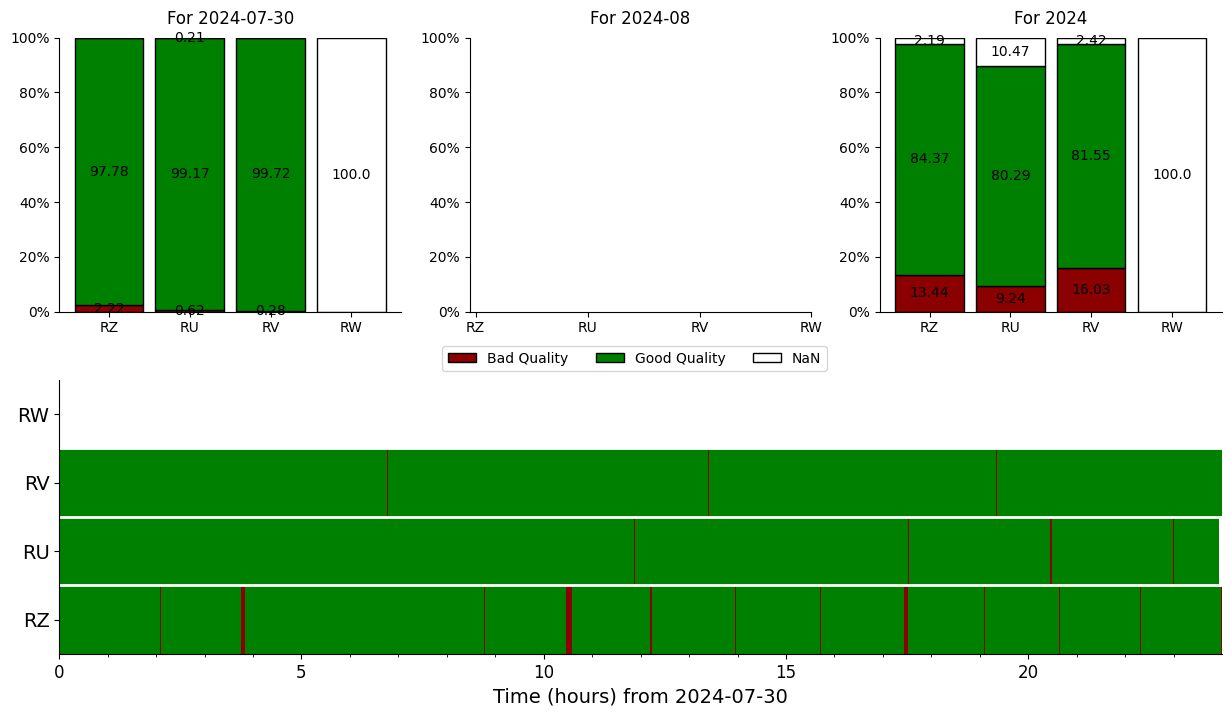

In [14]:
fig = __makeplot()

fig.savefig(config['path_to_figs']+f"html_status.png", format="png", dpi=150, bbox_inches='tight')

del fig